## Final Project Submission

Please fill out:
* Student name: Laura Lewis
* Student pace: full time
* Scheduled project review date/time: 15 May 2019, 3:30pm BST
* Instructor name: Joe San Pietro
* Blog post URL:
***

# Table of contents

[1. Introduction and project aims](#Introduction-and-project-aims)

[2. The dataset](#The-dataset)

[3. Cleaning and pre-processing](#Cleaning-and-pre-processing)

[4. Exploratory data analysis](#Exploratory-data-analysis)
   - [Time series](#Time-series)
   - [Numerical features](#Numerical-features)
   - [Categorical features](#Categorical-features)
   - [Boolean (true or false) features](#Boolean-(true-or-false)-features)

[5. Preparing the data for modeling](#Preparing-the-data-for-modeling)

[6. Building a neural network](#Building-a-neural-network)

[7. Conclusions and recommendations](#Conclusions-and-recommendations)

***

# Introduction and project aims

- Short description of Airbnb
- Why Airbnb pricing is important
- Difficult thing to do correctly, to balance revenue and occupancy (explanation)
- Several pricing algorithms out there, including Airbnb's own. But all of them require you to add a a base price first (and sometimes also a minimum and maximum price).
- This project aims to build a neural network to predict the base price for properties in London.

***

# The dataset

- Insideairbnb.com - anti-Airbnb lobby group that scrapes data
- Includes data on all Airbnb listings in London that are live on x (date)
- Limitations - messy data. Most importantly, only includes advertised price, not actual average price paid or the price advertised on the calendar - each day can have a different price.
- Advertised price is set by the listing owner and can be any amount. This is the price that you see on Airbnb if you don't enter dates. The sensible option is to set it at the lowest possible price that your property is actually listed at, in order to entice more customers in. However, a lot of people do not know how to set up Airbnb listings well, and so this is sometimes also set at very high values.
- This dataset can be used as a proof of concept. A more accurate version could be built using data on the actual average nightly rates paid, e.g. from sites like AirDNA.
- Also GeoJSON file of borough boundaries in the city from the same site.

***

# Cleaning and pre-processing

In this section...

### Importing the libraries and data

In [313]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd

In [314]:
raw_df = pd.read_csv('data/airbnb_listings_09-04-19.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 79671 Airbnb listings


C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190409040957,2019-04-11,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/985879/b06...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a day,60%,NaN,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,4 months ago,t,10,39,68,343,2019-04-11,14,3,2010-08-18,2018-06-17,95.0,9.0,10.0,9.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,3,1,2,0,0.13
1,15400,https://www.airbnb.com/rooms/15400,20190409040957,2019-04-11,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a few hours,100%,NaN,f,https://a0.muscache.com/i

### Dropping columns

NLP will not be used in the creation of an initial model (although they could be used to augment the model later, e.g. through sentiment analysis). Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [315]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

Other columns can be dropped because they contain a majority of null entries.

In [316]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                        248
host_response_time                              25699
host_response_rate                              25699
host_acceptance_rate                            79671
host_is_superhost                                 248
host_listings_count                               248
host_total_listings_count                         248
host_has_profile_pic                              248
host_identity_verified                            248
street                                              0
neighbourhood                                       0
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    79671
city                                              142
state                                           17389
zipcode                                          1938
market                      

In [317]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

In [318]:
df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

In [319]:
df.head(3)

,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13913,business,2009-11-16,within a day,60%,f,4.0,4.0,t,f,"Islington, Greater London, United Kingdom",LB of Islington,Islington,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",$65.00,$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,4 months ago,t,10,39,68,343,14,3,2010-08-18,2018-06-17,95.0,9.0,10.0,9.0,10.0,9.0,9.0,f,f,f,moderate,f,f,3,1,2,0,0.13
15400,romantic,2009-12-05,within a few hours,100%,f,1.0,1.0,t,t,"London, United Kingdom",Chelsea,Kensington and Chelsea,London,NaN,SW3,London,"London, United Kingdom",GB,United Kingdom,51.48796,-0.16898,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$100.00,$150.00,$50.00,2,$0.00,3,50,3,3,50,50,3.0,50.0,5 weeks ago,t,4,4,4,134,81,0,2009-12-21,2018-03-30,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.71
17402,none,2010-01-04,within a few hours,62%,t,16.0,16.0,t,t,"London, Fitzrovia, United Kingdom",Fitzrovia,Westminster,London,Fitzrovia,W1T4BP,London,"London, United Kingdom",GB,United Kingdom,51.52098,-0.14002,t,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",$500.00,$350.00,$65.00,4,$10.00,3,365,3,3,365,365,3.0,365.0,yesterday,t,30,60,89,364,39,14,2011-03-21,2018-10-15,93.0,10.0,9.0,9.0,9.0,10.0,9.0,f,f,f,strict_14_with_grace_period,f,f,13,13,0,0,0.40


host_listings_count and host_total_listings_count are the same in all but 248 cases. These cases are those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [320]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

248


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
381741,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",LB of Brent,Brent,London,NaN,NW10,London,"London, United Kingdom",GB,United Kingdom,51.53571,-0.24497,f,Apartment,Entire home/apt,6,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",$100.00,$250.00,$35.00,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,today,t,11,20,37,310,7,0,2012-06-10,2013-01-02,100.0,9.0,9.0,9.0,10.0,8.0,9.0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.08
388743,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Lee, London, United Kingdom",LB of Lewisham,Lewisham,Lee,London,SE12 0PT,London,"Lee, United Kingdom",GB,United Kingdom,51.45615,0.00956,f,Apartment,Private room,1,NaN,1.0,1.0,Real Bed,{Internet},$80.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,never,t,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,NaN
396100,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",LB of Bromley,Bromley,London,NaN,SE26 4EQ,London,"London, United Kingdom",GB,United Kingdom,51.42273,-0.05679,t,House,Private room,4,1.5,2.0,4.0,Real Bed,"{TV,Wifi,""Pets allowed"",""Pets live on this pro...",$60.00,$0.00,$0.00,4,$0.00,1,7,1,2,7,7,1.3,7.0,4 days ago,t,16,37,61,123,20,4,2017-04-04,2019-01-04,99.0,10.0,10.0,10.0,10.0,9.0,9.0,f,f,f,flexible,f,f,6,0,6,0,0.81
400441,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, United Kingdom",LB of Newham,Newham,London,NaN,E12 6UW,London,"London, United Kingdom",GB,United Kingdom,51.54841,0.04934,t,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",He...",$30.00,NaN,NaN,1,$20.00,180,1825,180,180,1825,1825,180.0,1825.0,21 months ago,t,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,moderate,f,f,1,0,1,0,NaN
423592,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Barking, United Kingdom",LB of Barking and Dagenham,Barking and Dagenham,Barking,NaN,IG11 8LJ,London,"Barking, United Kingdom",GB,United Kingdom,51.53922,0.07048,t,Apartment,Private room,2,0.0,1.0,1.0,Real Bed,{},$70.00,NaN,NaN,1,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,85 months ago,t,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f,1,0,1,0,NaN


In [321]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in London, columns relating to city and country can be dropped. One columns for area (borough) will be kept - 'neighboorhood_cleansed'. 'Zipcode' (postcode) will be kept for now and investigated further below.

In [322]:
df.drop(['street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [323]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

4698

In [324]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

In [325]:
df.head(3)

,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13913,business,2009-11-16,within a day,60%,f,4.0,t,f,Islington,N4 3,51.56802,-0.11121,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",$65.00,$100.00,$15.00,1,$15.00,1,29,4 months ago,t,10,39,68,343,14,3,2010-08-18,2018-06-17,95.0,9.0,10.0,9.0,10.0,9.0,9.0,f,f,f,moderate,f,f,0.13
15400,romantic,2009-12-05,within a few hours,100%,f,1.0,t,t,Kensington and Chelsea,SW3,51.48796,-0.16898,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$100.00,$150.00,$50.00,2,$0.00,3,50,5 weeks ago,t,4,4,4,134,81,0,2009-12-21,2018-03-30,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,strict_14_with_grace_period,t,t,0.71
17402,none,2010-01-04,within a few hours,62%,t,16.0,t,t,Westminster,W1T4BP,51.52098,-0.14002,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",$500.00,$350.00,$65.00,4,$10.00,3,365,yesterday,t,30,60,89,364,39,14,2011-03-21,2018-10-15,93.0,10.0,9.0,9.0,9.0,10.0,9.0,f,f,f,strict_14_with_grace_period,f,f,0.40


### Description of each column:
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_has_profile_pic - whether or not the host has provided a picture of themselves
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the London borough the property is in
- zipcode - postcode of the property
- latitude - Location information for listings are anonymized by Airbnb, and so the data will be from 0-450 feet (150 metres) of the actual address
- longitude - as above
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- calendar_updated - when the host last updated the calendar
- has_availability - whether there are any nights available to be booked
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- requires_license - whether or not the property requires a license to operate on Airbnb
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
- is_business_travel_ready - whether or not the property is deemed to be particularly suitable for business travel, which comes with certain requirements (e.g. WiFi)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- require_guest_profile_picture - whether or not the guest is required to have a profile picture in order to book
- require_guest_phone_verification - whether or not the guest is required to have a phone number verified in order to book
- reviews_per_month - calculated field of the average number of reviews left by guest each month

### Cleaning individual columns

**host_since**

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (9 April 2019). The original column will be left in initially for EDA, and dropped later.

In [326]:
df.host_since = pd.to_datetime(df.host_since) # Converting to datetime

In [327]:
# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

In [328]:
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

Mean days as host: 1336.0
Median days as host: 1328.0


In [329]:
# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

**host_response_time**

About a third of rows don't have a value for host_response_time, and the majority of these have also not yet been reviewed. Therefore this section of the dataset consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area. The latter occurs in some cases when people who regularly live in a property put their property on Airbnb at a high price just to see if anyone is willing to book at that price (some Airbnb listings are indeed booked at very high prices). Then if their property is booked, they will decamp to a cheaper hotel for those dates, and pocket the difference in price.

Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [330]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

Null values: 25699
Proportion: 32.3%


In [331]:
# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


20342

In [332]:
# Proportions in each category
df.host_response_time.value_counts(normalize=True)

within an hour        0.625806
within a few hours    0.197806
within a day          0.145298
a few days or more    0.031090
Name: host_response_time, dtype: float64

In [333]:
df.host_response_time.fillna("unknown", inplace=True)

In [334]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.423943
unknown               0.322564
within a few hours    0.134001
within a day          0.098430
a few days or more    0.021062
Name: host_response_time, dtype: float64

**host_response_rate**

A similar story is true for host_response_rate, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [335]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 25699
Proportion: 32.3%


In [336]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

In [337]:
print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 69.9%


Histogram of host response times


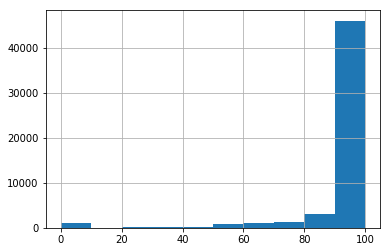

In [338]:
print("Histogram of host response times")
df.host_response_rate.hist();

In [339]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

In [340]:
# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       37730
unknown    25699
50-89%      7346
90-99%      6519
0-49%       2377
Name: host_response_rate, dtype: int64

**host_is_superhost**

There are 248 rows lacking values for each of five different host-related features. These rows will be dropped.

In [341]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


248

In [342]:
df.dropna(subset=['host_since'], inplace=True)

**zipcode**

Postcodes in the UK are complicated and messy. They can be various lengths, and consist of letters and numbers in various orders. The first half of a postcode is called the outcode or postcode district, and refers to areas as shown in the top image below. Just to make things more complicated, the main geographic division of London is into 32 boroughs plus the City of London (technically a Corporation rather than a borough due to some quirks of 12th Century English history), which do not align with postcode districts (as seen in the bottom image below).

London postcode districts:
<img src="images/London_outcodes.png" width="500">

London postcode districts (red), layered over London boroughs (black lines):
<img src="images/London_boroughs_and_outcodes.png" width="500">

In fact, there is not even agreement on what counts as 'inner London':

(Image source: https://en.wikipedia.org/wiki/Inner_London)
<img src="images/Inner_London.png" width="250">

Postcode districts are on a more granular geographic scale than boroughs, and so in theory it would be preferable to use these instead of boroughs. However, this would require the one-hot encoding of postcode districts in categories, which would result in the addition of hundreds of extra features.

Therefore, for the purposes of creating a functional pricing model, borough will be used instead of zipcode. Alternative versions could be to use postcode districts, or to incorporate latitude and longitude into the model, and these can be explored in the future.

For now, zipcode will be dropped.

In [343]:
df.drop('zipcode', axis=1, inplace=True)

**bathrooms**

Missing values will be replaced with the median (to avoid strange fractions).

In [344]:
print("Null values:", df.bathrooms.isna().sum())
print("Median value:", df.bathrooms.median())

Null values: 143
Median value: 1.0


In [345]:
df.bathrooms.fillna(df.bathrooms.median(), inplace=True)

**bedrooms**

Missing values will be replaced with the median.

In [346]:
print("Null values:", df.bedrooms.isna().sum())
print("Median value:", df.bedrooms.median())

Null values: 37
Median value: 1.0


In [347]:
df.bedrooms.fillna(df.bedrooms.median(), inplace=True)

**beds**

Missing values will be replaced with the median.

In [348]:
print("Null values:", df.beds.isna().sum())
print("Median value:", df.beds.median())

Null values: 133
Median value: 1.0


In [349]:
df.beds.fillna(df.beds.median(), inplace=True)

**amenities**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [350]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,"Cable TV",Wifi,Kitchen,"Paid parking off premises","Smoking allowed","Free street parking","Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Outlet covers",Bathtub,"Children’s books and toys","Babysitter recommendations",Crib,"Pack ’n Play/travel crib","Room-darkening shades","Children’s dinnerware","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection","Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony","Luggage dropoff allowed","Long term stays allowed","Step-free access","Wide doorway","Wide clearance to bed","Accessible-height bed","Step-free access","Wide doorway","Bathtub with bath chair","Accessible-height toilet","Host greets you","Handheld shower head","Roll-in shower"}'],
      dtype=object)

In [351]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]

In [352]:
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alfresco bathtub',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 "Chef's kitchen",
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Dining area',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',


In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed'). Based on previous experience working in the Airbnb property management industry, and research into which amenities are considered by guests to be more important, a selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):
- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Bathtub/alfresco bathtub
- Bathroom essentials
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Building staff/doorman
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dining area/formal dining area
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- En suite bathroom
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private bathroom
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [353]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Bathtub|Alfresco bathtub'), 'bath'] = 1
df.loc[df['amenities'].str.contains('Bathroom essentials'), 'bathroom_essentials'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('Building staff|Doorman'), 'staff'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dining area|Formal dining area'), 'dining_area'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('En suite bathroom'), 'en_suite'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private bathroom'), 'private_bathroom'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [358]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,51:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

In [359]:
df.drop('amenities', axis=1, inplace=True)

**price**

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [360]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

**security_deposit**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

Having a missing value for security deposit is functionally the same as having a security deposit of £0, so missing values will be replaced with 0.

In [361]:
df.security_deposit.isna().sum()

28197

In [362]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

**cleaning_fee**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of £0, so missing values will be replaced with 0.

In [363]:
df.cleaning_fee.isna().sum()

20969

In [364]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

**extra_people**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of £0, so missing values will be replaced with 0.

In [365]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

**first_review and last_review**

About a quarter of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [366]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 25.4%
Null values in 'review_scores_rating': 27.5%


In [367]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

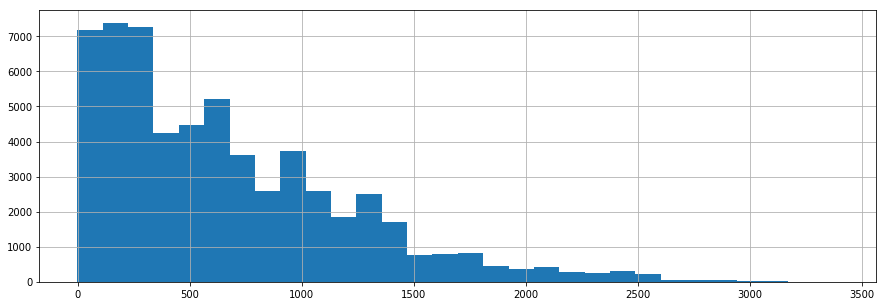

In [368]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [369]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [370]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for last_review:

In [371]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

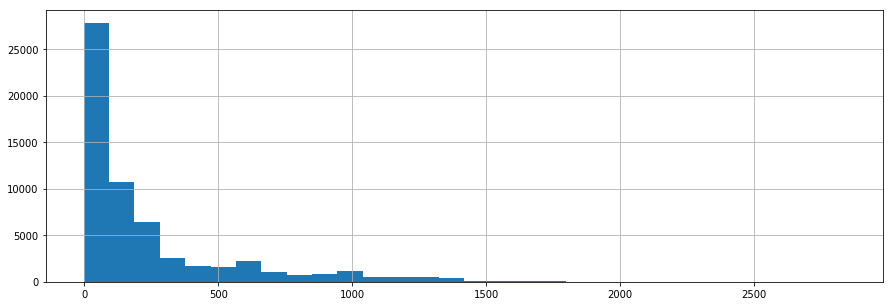

In [372]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [373]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [374]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

**review ratings columns**

As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

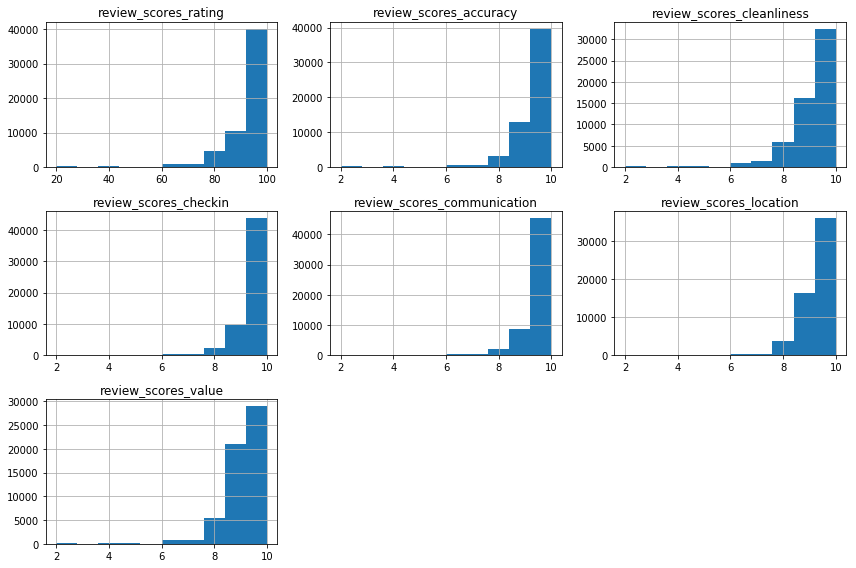

In [375]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [376]:
df.review_scores_accuracy.value_counts()

10.0    39514
9.0     12935
8.0      3270
7.0       665
6.0       634
2.0       254
4.0       149
5.0       104
3.0         8
Name: review_scores_accuracy, dtype: int64

In [377]:
# Example of a binned category
df.review_scores_accuracy.value_counts()

10.0    39514
9.0     12935
8.0      3270
7.0       665
6.0       634
2.0       254
4.0       149
5.0       104
3.0         8
Name: review_scores_accuracy, dtype: int64

In [378]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [379]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [380]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

**reviews_per_month**

For reviews per month, null values will be replaced with 0, as it is correct to say that these listings have had 0 reviews for all of the months that they have been active. Also, the vast majority of listings get 0-1 reviews per month on average, so this is a reasonable number to replace them with.

In [381]:
df.reviews_per_month.isna().sum()

20162

Reviews per month


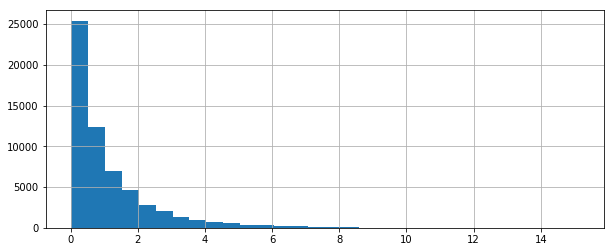

In [382]:
print("Reviews per month")
df.reviews_per_month.hist(figsize=(10,4), bins=30);

In [383]:
df.reviews_per_month.fillna(0, inplace=True)

***

# Exploratory data analysis

In this section...

### Time series

*Question: how long have hosts been listing properties on Airbnb in London?*

Answer: the oldest listing that is currently live on Airbnb was first listed on the site in August 2008. From 2011 onwards, the number of listings started to increase, with a particularly large increase in 2015, although growth in the number of new hosts (of those currently listing on the site) has decreased slightly from 2015 to 2019.

The growth in the number of live listings (as determined by the date of a listing's first review) tells a slightly different story to that of hosts, however. This number began to increase considerably since the start of 2015 and is still increasing at a rapid rate - with notable peaks in the summer when people put properties online to take advantage of the increased number of tourists in the summer holidays.

In [386]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 14 August 2008, and the most recent joined on 08 April 2019.


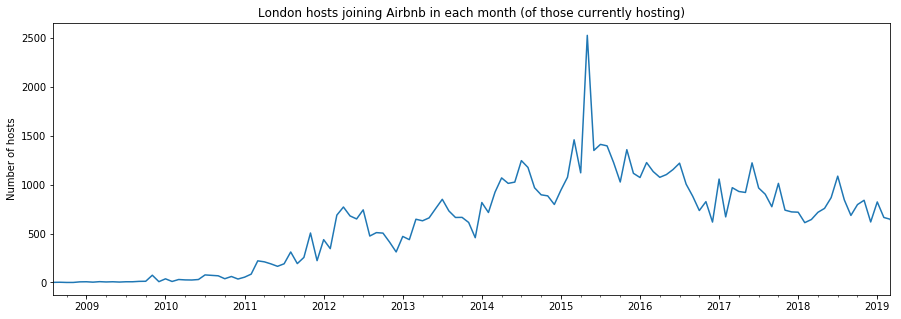

In [392]:
plt.figure(figsize=(15,5))
df.set_index('host_since').latitude.resample('MS').count().plot()
plt.title('London hosts joining Airbnb in each month (of those currently hosting)')
plt.xlim('2008-08-01', '2019-03-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('Number of hosts')
plt.show()

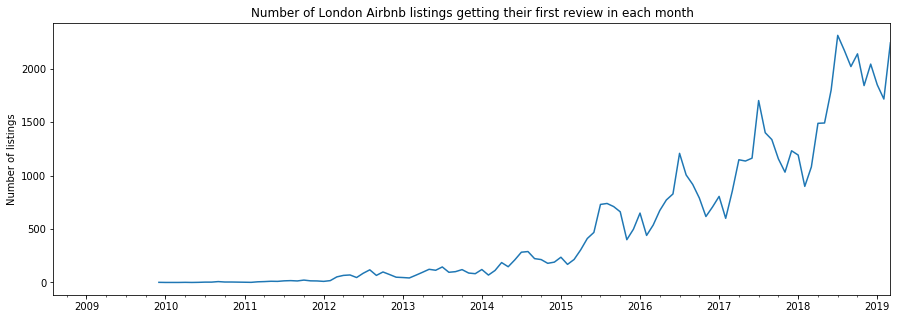

In [394]:
plt.figure(figsize=(15,5))
df.set_index('first_review').latitude.resample('MS').count().plot()
plt.title('Number of London Airbnb listings getting their first review in each month')
plt.xlim('2008-08-01', '2019-03-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('Number of listings')
plt.show()

*Question: are the different patterns in the growth in the number of hosts and the number of listings due to hosts increasingly owning multiple properties?*

Answer: there are a number of professional Airbnb management companies which host a large number of listings under a single host profile, particularly from 2013 onwards. The largest manages 1654 listings and is aa management company based in Liverpool operating under the name 'Jp', while the second largest is the management company Veeve, managing 1304 listings.

However, there is no consistent upwards trend in the average number of properties managed by each host.

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


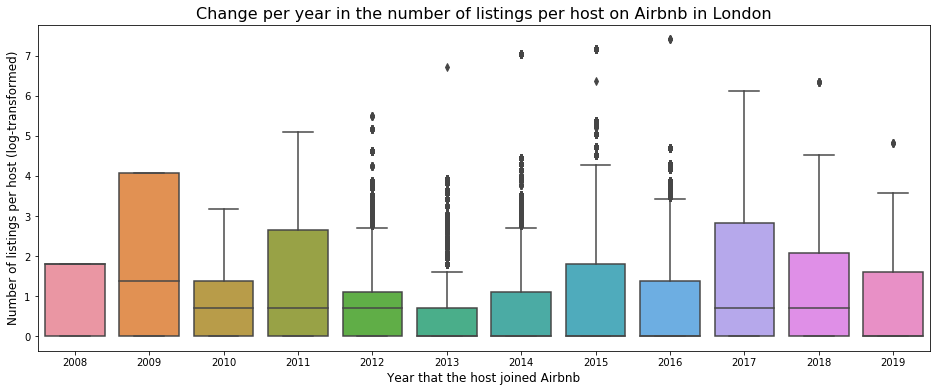

In [403]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in London', fontsize=16)
plt.show()

In [401]:
print("Average number of listings per host per year on Airbnb in London:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in London:
host_since
2008-01-01      4.33
2009-01-01     24.10
2010-01-01      4.29
2011-01-01     18.70
2012-01-01      6.56
2013-01-01      4.00
2014-01-01     12.42
2015-01-01    100.15
2016-01-01      7.19
2017-01-01     27.36
2018-01-01     10.25
2019-01-01      5.53
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [434]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
22750548,2015-11-04,189.0
19617790,2015-03-05,217.0
20977631,2012-11-13,246.0
30525581,2017-10-25,457.0
32398252,2018-03-12,571.0
22005669,2015-04-25,586.0
13229041,2013-02-12,829.0
24917631,2014-02-14,1145.0
18203920,2015-05-21,1304.0


*Question: how have prices changed over time?*

Answer: the average price per night for Airbnb listings in London has increased slightly over the last 10 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median - e.g. the mean price in 2015 was £95.90, whereas the mean price in 2018 (the last complete year of data) was £111.14.

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


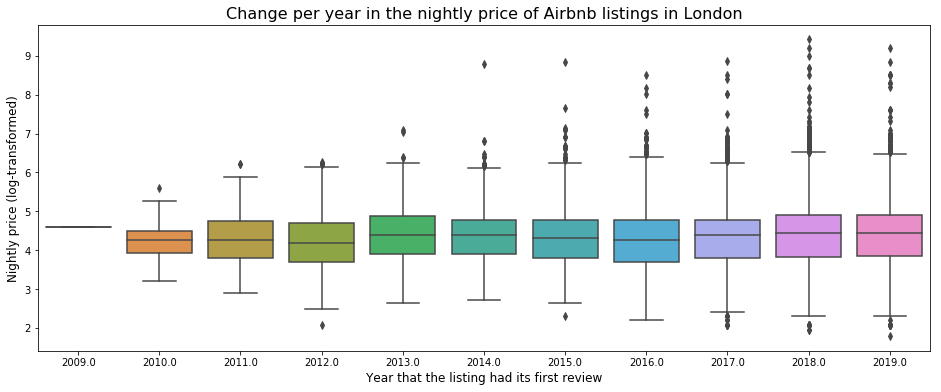

In [439]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in London', fontsize=16)
plt.show()

In [445]:
print("Mean nightly price of listings in each year on Airbnb in London:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in London:
first_review
2009-01-01    100.00
2010-01-01     85.04
2011-01-01     93.97
2012-01-01     86.28
2013-01-01    101.35
2014-01-01    101.54
2015-01-01     95.90
2016-01-01     96.19
2017-01-01    100.41
2018-01-01    111.14
2019-01-01    124.30
Name: price, dtype: float64


In [444]:
print("Median nightly price of listings in each year on Airbnb in London:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year on Airbnb in London:
first_review
2009-01-01    100
2010-01-01     70
2011-01-01     70
2012-01-01     65
2013-01-01     80
2014-01-01     80
2015-01-01     75
2016-01-01     71
2017-01-01     80
2018-01-01     85
2019-01-01     85
Name: price, dtype: int64


In [459]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

### Numerical features

In [597]:
df.describe()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,reviews_per_month,host_days_active
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,7.942300e+04,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,29.815482,51.509460,-0.128262,3.175201,1.290892,1.407162,1.738728,116.720333,133.148118,30.664178,1.569709,7.414452,4.096345,4.198981e+04,8.325309,18.960402,30.062337,114.762915,15.978004,6.705765,0.847037,1335.540309
std,159.114327,0.046115,0.091533,1.996260,0.605444,0.904378,1.266215,208.965892,276.610258,41.850741,1.293974,13.893068,15.373230,8.413339e+06,10.448091,21.830930,33.329813,130.091001,33.756707,12.615766,1.265594,745.679201
min,0.000000,51.294790,-0.501300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,51.485360,-0.187880,2.000000,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,744.000000
50%,2.000000,51.513820,-0.125570,2.000000,1.000000,1.000000,1.000000,80.000000,0.000000,20.000000,1.000000,0.000000,2.000000,1.125000e+03,3.000000,9.000000,15.000000,61.000000,4.000000,1.000000,0.340000,1328.000000
75%,5.000000,51.537280,-0.070510,4.000000,1.500000,2.000000,2.000000,135.000000,200.000000,45.000000,2.000000,10.000000,3.000000,1.125000e+03,15.000000,37.000000,60.000000,222.000000,16.000000,8.000000,1.120000,1835.000000
max,1654.000000,51.681690,0.317520,16.000000,17.000000,16.000000,23.000000,13700.000000,4098.000000,614.000000,16.000000,235.000000,1125.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,630.000000,194.000000,15.120000,3890.000000


**Price**

*Question: what is the overall distribution of prices?*

Answer:

**Host listings count**

*Question: how many listings do hosts have on average? How many multi-listing hosts are there?*

Answer: the median number of listings that the host of each listing has is 2, i.e. on average (median) each listing is hosted by a host who also manages one other listing. The mean is much higher (30 in total) due to some hosts managing large numbers of listings (as discussed above in the Time Series section). About half of listings are from hosts with one listing, and half are from multi-listing hosts. 

Two difficulties in discerning how many listings hosts have on average are:
- this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)
- a host's other listings may not be in London, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [619]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 30
49% of listings are from hosts with one listing.


**Latitude and longitude**

*Question: how are properties distributed accross London on a granular scale?*

Answer:

**Number of people accommodated, guests included, bathrooms, bedrooms and beds**

*Question: what are the average number of people accommodated, guests included in the price, bathrooms, bedrooms and beds in Airbnb listings in London?*

Answer:

**Security deposit, cleaning fee and extra people fee**

*Question: what are the average security deposits, cleaning fees and extra people fees set by hosts?*

Answer:

**Minimum and maximum nights stay**

*Question: what are the average minimum and maximum nights stay?*

Answer:

**Availability**

*Question: how much availability do listings tend to have?*

Answer:

**Number of reviews and reviews per month**

*Question: how many reviews do Airbnb listings tend to get (overall, per year and per month)?*

Answer:

### Categorical features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

In [446]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

**Experiences offered**

*Question: do hosts often offer their guests extra experiences?*

Answer: the vast majority of listings do not offer experiences. This column will be dropped because it does not provide much information and cannot be used to distinguish between listings particularly well.

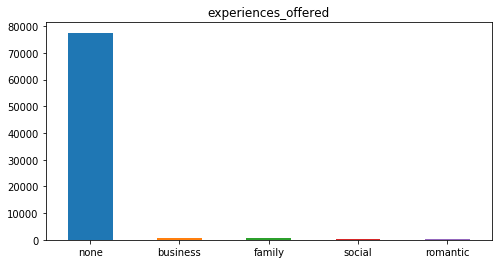

In [447]:
category_count_plot('experiences_offered')

In [448]:
df.drop('experiences_offered', axis=1, inplace=True)

**Host response time and rate**

*Question: how quickly and how frequently do hosts respond to messages from guests or potential bookers?*

Answer: most hosts respond to messages within an hour, which is surprisingly fast. Very few mosts take more than a few days to respond - which is not surprising, as they are likely to miss out on bookings.

Most hosts respond to all of the messages sent by guests - which is good news for guests. Very few hosts respond to fewer than half of messages - which is also not surprising, as these hosts presumably miss out on bookings.

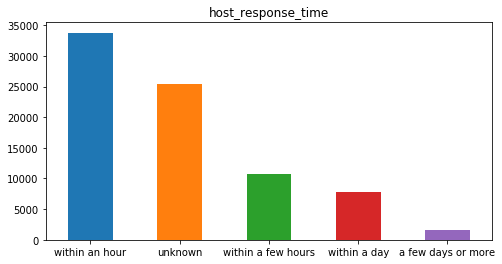

In [449]:
category_count_plot('host_response_time')

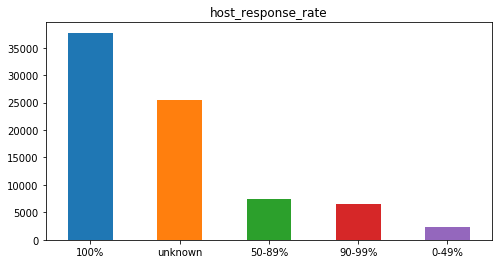

In [450]:
category_count_plot('host_response_rate')

**Neighbourhood**

*Question: which areas have the most Airbnb properties, and which are the most expensive?* 

Answer: Westminster (west central London) has the most Airbnb properties, followed by Tower Hamlets (east central London). There is a notable difference in the number of listings between inner London (more listings) and outer London (fewer listings) boroughs.

However, the pattern with prices is slightly different. Kensington and Chelsea (to the west of Westminster) is the most expensive area - this is a famously expensive area to live, with some of the highest house prices in the world. Although inner London is generally more expensive than outer London, there are also some more expensive listings spread out to the west of the city along the Thames (which has some very beautiful areas).

In [451]:
# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('data/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"(POLYGON ((-0.330679 51.329011, -0.330594 51.3..."
1,Croydon,None,"(POLYGON ((-0.06402099999999999 51.318638, -0...."
2,Bromley,None,"(POLYGON ((0.012131 51.299599, 0.011962 51.299..."
3,Hounslow,None,"(POLYGON ((-0.244562 51.488702, -0.24468 51.48..."
4,Ealing,None,"(POLYGON ((-0.411833 51.534084, -0.411883 51.5..."


In [452]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

In [453]:
# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('neighbourhood_cleansed').price.count())
borough_df.rename(columns={'price': 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('neighbourhood_cleansed').price.median().values
borough_df.head()

,number_of_listings,median_price
neighbourhood_cleansed,,
Barking and Dagenham,297,41
Barnet,1487,54
Bexley,242,40
Brent,2287,60
Bromley,627,50


In [454]:
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)
borough_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
Kingston upon Thames,"(POLYGON ((-0.330679 51.329011, -0.330594 51.3...",501,50
Croydon,"(POLYGON ((-0.06402099999999999 51.318638, -0....",1032,45
Bromley,"(POLYGON ((0.012131 51.299599, 0.011962 51.299...",627,50
Hounslow,"(POLYGON ((-0.244562 51.488702, -0.24468 51.48...",976,60
Ealing,"(POLYGON ((-0.411833 51.534084, -0.411883 51.5...",1564,55


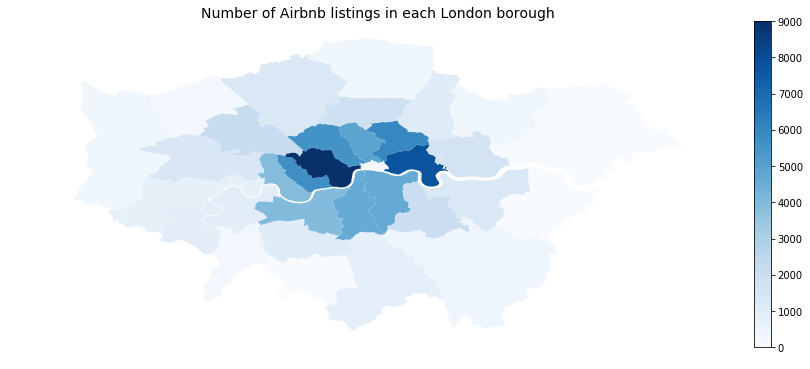

In [455]:
fig, ax = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax)
ax.axis('off')
ax.set_title('Number of Airbnb listings in each London borough', fontsize=14)

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig.colorbar(sm)

plt.show()

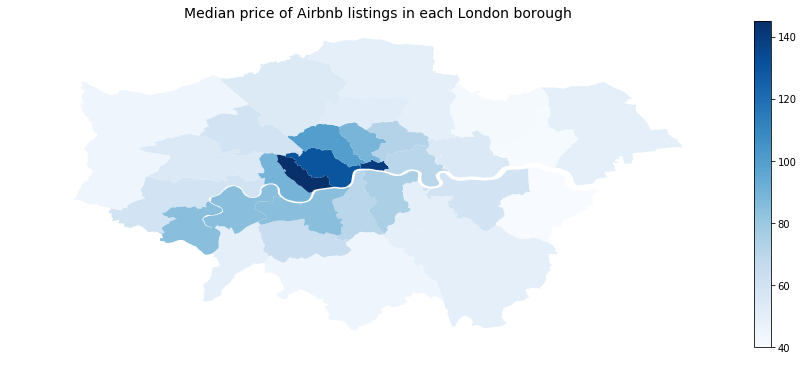

In [456]:
fig, ax = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax)
ax.axis('off')
ax.set_title('Median price of Airbnb listings in each London borough', fontsize=14)

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig.colorbar(sm)

plt.show()

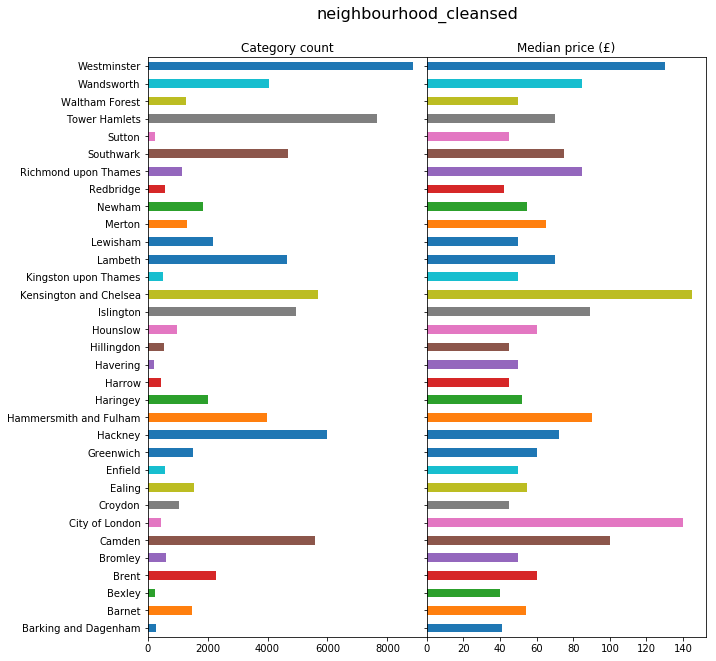

In [457]:
# Same data in bar chart form
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('neighbourhood_cleansed', fontsize=16, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
df.groupby('neighbourhood_cleansed').price.count().plot(kind='barh', ax=ax1)
ax1.set_title('Category count')
ax1.set_ylabel('')
    
df.groupby('neighbourhood_cleansed').price.median().plot(kind='barh', ax=ax2)
ax2.set_title('Median price (£)')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')

plt.show()

**Property, room and bed types**

*Question: what are the most common property, room and bed types?*

Answer: about 70% of properties are apartments. The remainder are houses or more uncommon property types (e.g. 'bed and breakfast' or 'yurt').

About 55% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

99% of listings have real beds - the remainder are a mix of pull-out sofas, futons, couches and airbeds. This category therefore does not provide much information to differentiate between listings, and will be dropped.

Some cleaning of property types was required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [463]:
df.property_type.value_counts()

Apartment                 53857
House                     16116
Townhouse                  2913
Serviced apartment         2144
Bed and breakfast           890
Condominium                 888
Loft                        718
Guest suite                 323
Guesthouse                  254
Other                       219
Hostel                      214
Boutique hotel              209
Bungalow                    125
Hotel                       112
Cottage                      86
Aparthotel                   62
Villa                        54
Boat                         53
Tiny house                   38
Houseboat                    24
Cabin                        24
Casa particular (Cuba)       20
Camper/RV                    19
Hut                           9
Earth house                   9
Chalet                        7
Barn                          7
Farm stay                     5
Yurt                          4
Treehouse                     3
Nature lodge                  3
Dome hou

In [465]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

In [467]:
# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

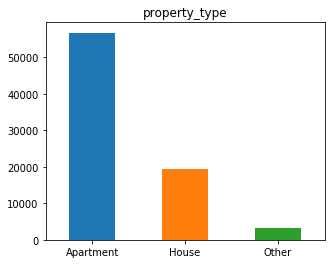

Apartment    0.714138
House        0.243607
Other        0.042255
Name: property_type, dtype: float64


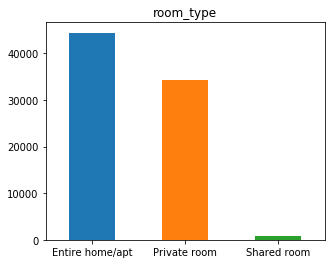

Entire home/apt    0.559120
Private room       0.431600
Shared room        0.009279
Name: room_type, dtype: float64


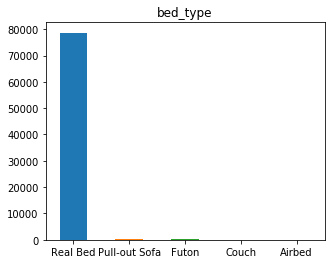

Real Bed         0.990343
Pull-out Sofa    0.005641
Futon            0.002455
Couch            0.000932
Airbed           0.000630
Name: bed_type, dtype: float64


In [482]:
for col in ['property_type', 'room_type', 'bed_type']:
    category_count_plot(col, figsize=(5,4))
    print(df[col].value_counts(normalize=True))

In [483]:
# Dropping bed_type
df.drop('bed_type', axis=1, inplace=True)

**Calendar updates**

*Question: how often do owners update their listings' calendars?*

Answer: about a quarter of Airbnb listings had their calendars updated on the same day they were scraped. It is slightly unclear what this means in practical terms for each case, but most likely includes new dates being opened up or blocked, or prices changed (e.g. because an automatic pricing algorithm is being used).

The large number of categories, and the fact that it is unclear what exactly this column is telling us, suggest that the column can be dropped.

In [487]:
# Number of categories
df.calendar_updated.nunique()

96

In [490]:
df.calendar_updated.value_counts(normalize=True)[:5]

today           0.252219
a week ago      0.058069
2 weeks ago     0.052139
yesterday       0.044206
2 months ago    0.040215
Name: calendar_updated, dtype: float64

In [491]:
df.drop('calendar_updated', axis=1, inplace=True)

**Reviews**

*Question: what is the distribution of reviews like?*

Answer: for  every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall) - clearly people love their Airbnbs. Ratings or 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, about a quarter of listings have not yet been reviewed.

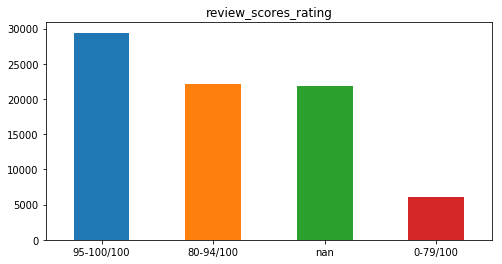

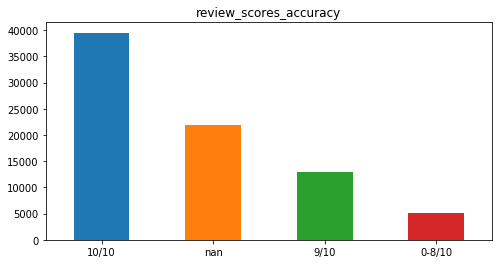

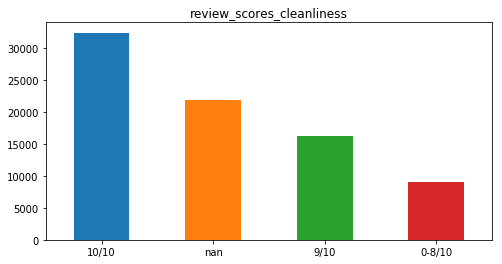

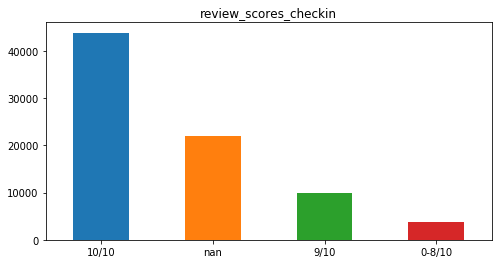

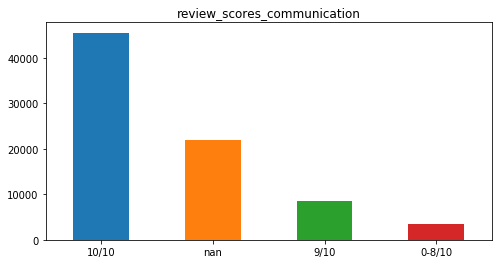

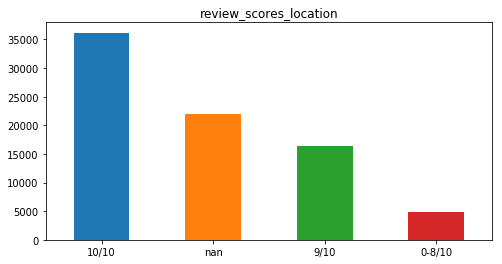

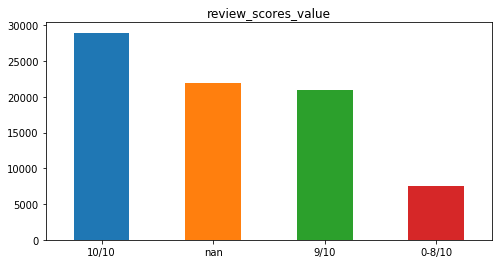

In [494]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col)

**Cancellation policy**

*Question: how strict are cancellation policies on Airbnb?*

Answer: the most common type is the 14 day strict policy, which refunds the full amount for cancellations more than 14 days in advance, 50% for cancellations before 7 days, and no refund after that.

The second most common type is flexible, which is the most lenient option and allows a guest to get all but the first night's  fee refunded for cancellations more than 24 hours in advance.

The least common type is moderate, which refunds the full amount for cancellations more than 5 days in advance, and 50% (minus the first night) after that.

Some cleaning of cancellation policy types was required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [499]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    33601
flexible                       25872
moderate                       19066
super_strict_30                  448
super_strict_60                  419
strict                             9
luxury_moderate                    8
Name: cancellation_policy, dtype: int64

In [502]:
# Replacing categories that are types of houses or apartments
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

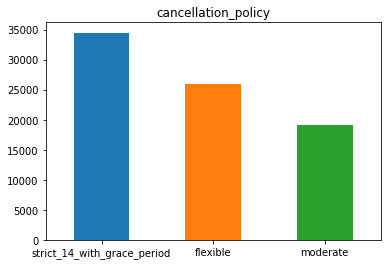

In [507]:
category_count_plot('cancellation_policy', figsize=(6,4))

**First and last reviews**

*Question: how long have listings been on the site, and how many listings have been reviewed recently?*

Answer: the most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for more than four years, however.

The most common category for the time since a listing received its last review is 2-8 weeks. This means that a lot of listings have been reviewed relatively recently. However, there are still over 10,000 listings which have not had a review for more than a year. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

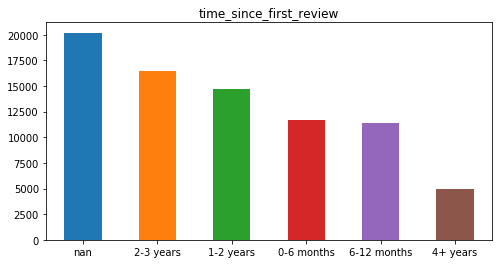

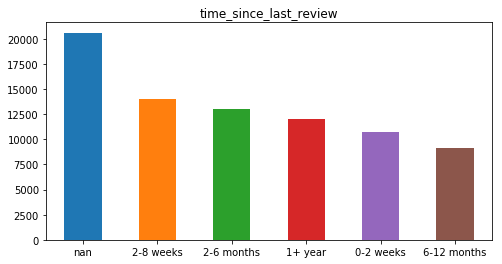

In [510]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### Boolean (true or false) features

Many features (e.g. for amenities) can be true or false. This section compares the proportions of these features that are true or false (to explore the data and also to ascertain whether the feature is worth retaining), and the median price of each category (to explore the relationship between the category and price).

In [518]:
# For the amenities categories, changing 1s to t and 0s to f, so that they use the same notation as other categories
df.iloc[:,44:-2] = df.iloc[:,44:-2].astype('str') # Converting to strings

for col in df.iloc[:,44:-2].columns:
    df[col].replace({'0.0': 'f', '1.0': 't'}, inplace=True)

In [524]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).price.count().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

*Question: what proportion of Airbnb hosts are superhosts, and is it worth being one?*

Answer: about 15% of hosts are superhosts. However, it does not seem to improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it (from a purely financial perspective).

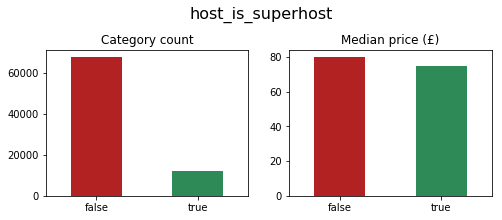

f    0.8509
t    0.1491
Name: host_is_superhost, dtype: float64


In [525]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

**Host profile pictures and identification**

*Question: how many hosts have profile pictures and are verified, and is it worth it?*

Answer: almost all hosts have a profile picture. Although listings associated with these hosts seem to have slightly higher median nightly prices, this is likely an artefact of the very small number of hosts without. This category can be dropped as it does not provide much information.

The majority of hosts are not actually verified (e.g. by providing ID and verifying your phone number and email address). Interestingly, however, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, there is no discernable difference between the median nightly prices of listings with verified and unverified hosts. This column will be left in the dataframe, however, in case it has any useful interactions with other features.

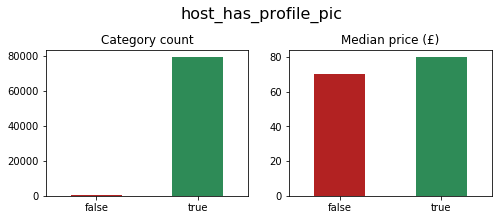

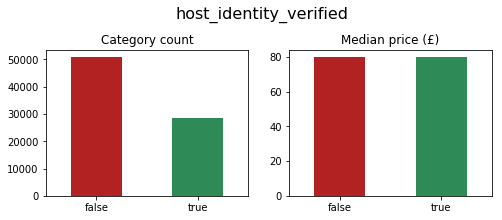

In [527]:
for col in ['host_has_profile_pic', 'host_identity_verified']:
    binary_count_and_price_plot(col)

In [528]:
# Dropping column
df.drop('host_has_profile_pic', axis=1, inplace=True)

**Availability**

*Question: how many listings are 'inactive'?*

Answer: it appears that for some reason all listings are counted as 't', i.e. having availability. Therefore this column can be dropped.

In [534]:
df.has_availability.value_counts()

t    79423
Name: has_availability, dtype: int64

In [535]:
df.drop('has_availability', axis=1, inplace=True)

**Instant booking**

*Question: how many properties are instant bookable (i.e. able to be booked without messaging the host first), and is it worth it?*

Answer: only about 40% of properties are instant bookable. However, the added convenience does not seem to have any effect on the median price per night.

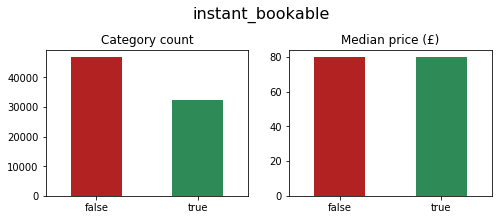

f    0.591139
t    0.408861
Name: instant_bookable, dtype: float64


In [539]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

**Business travel ready**

*Question: how many listings are business travel ready, and does this affect price?*

Answer: it seem that this option is not yet being used by hosts. The column will be dropped.

In [541]:
df.is_business_travel_ready.value_counts()

f    79423
Name: is_business_travel_ready, dtype: int64

In [542]:
df.drop('is_business_travel_ready', axis=1, inplace=True)

**Requiring guest profile pictures and phone verification**

*Question: how many listings require that the guest's identity is verified?*

Answer: hardly any. These columns will be dropped.

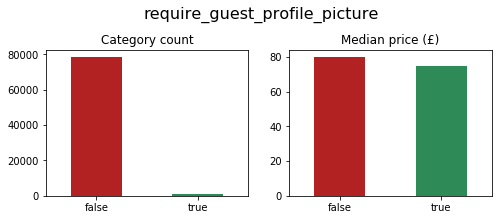

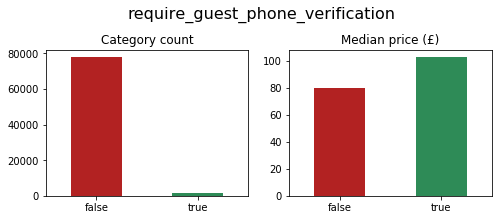

In [544]:
for col in ['require_guest_profile_picture', 'require_guest_phone_verification']:
    binary_count_and_price_plot(col)

In [545]:
df.drop(['require_guest_profile_picture', 'require_guest_phone_verification'], axis=1, inplace=True)

**Amenities**

*Question: which amenities are common, and which increase the price of an Airbnb listing?*

Answer: 

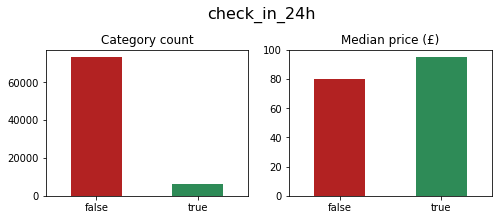

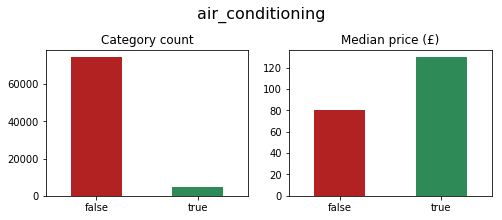

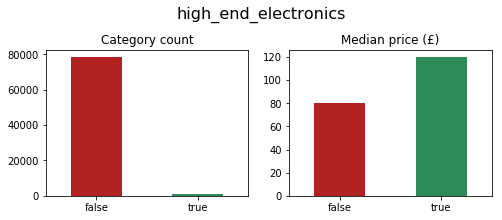

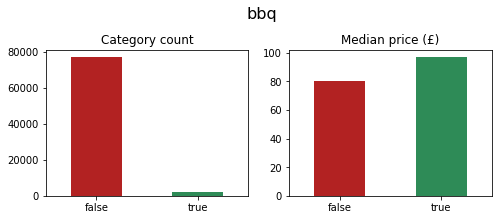

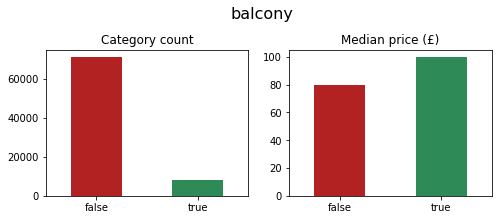

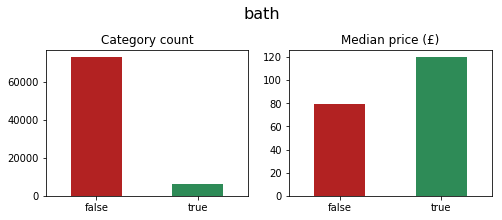

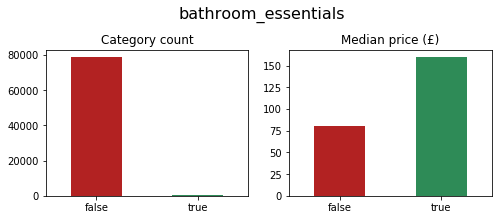

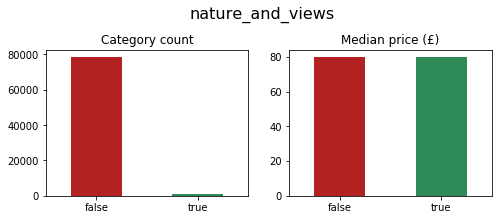

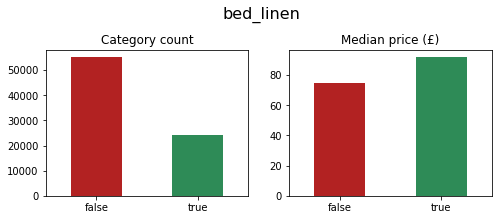

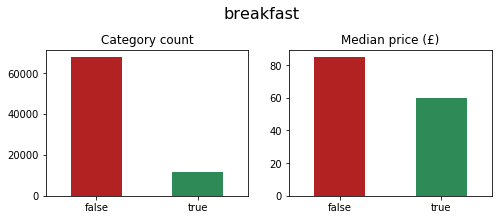

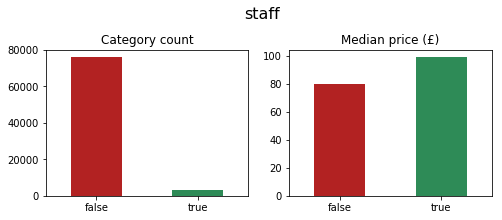

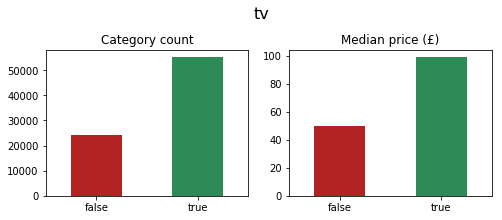

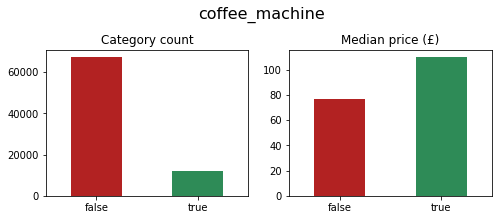

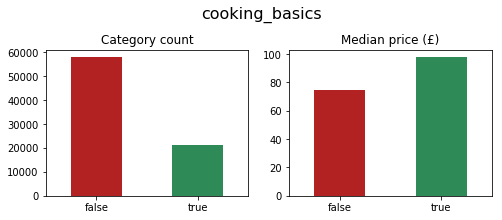

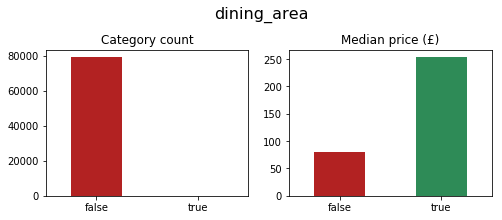

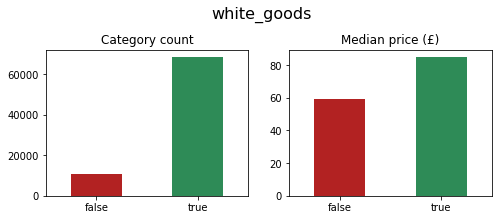

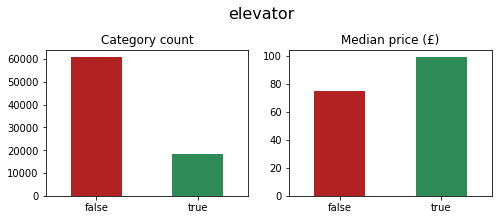

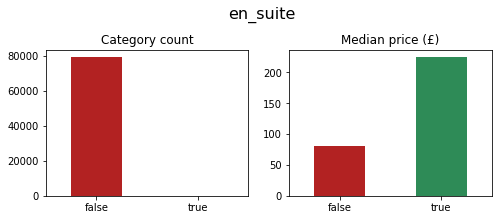

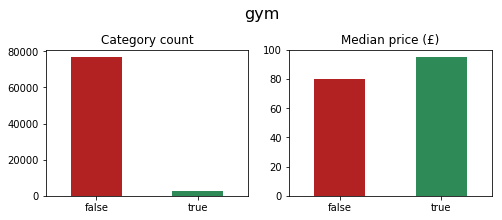

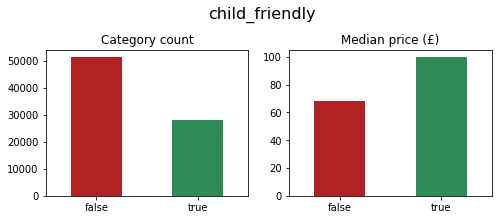

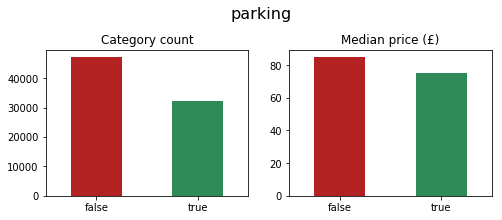

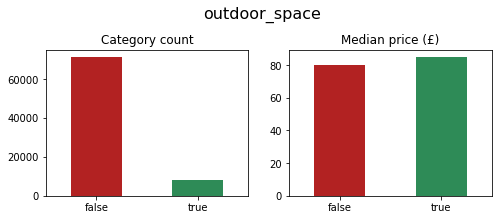

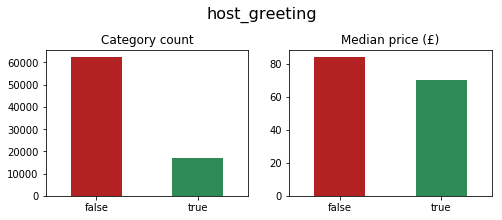

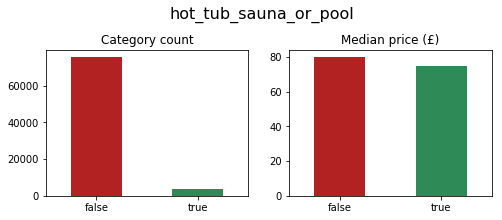

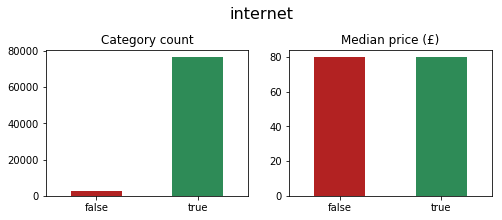

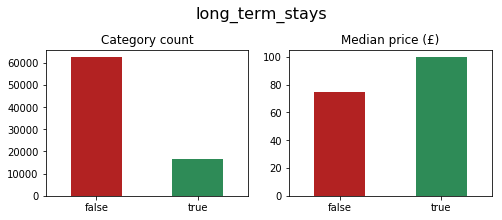

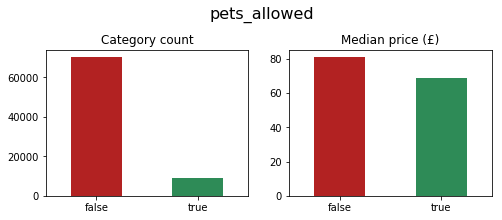

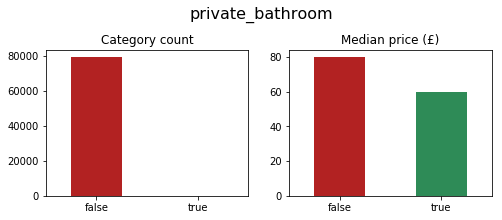

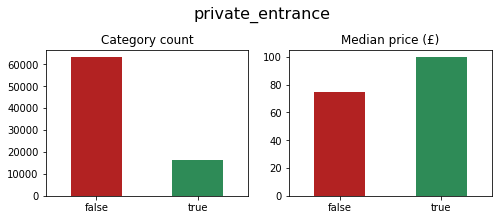

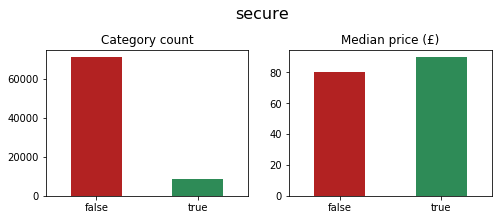

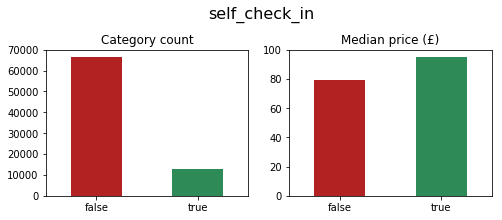

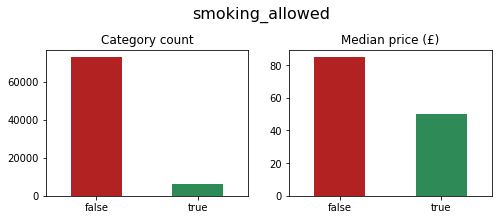

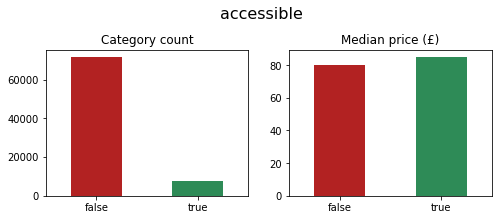

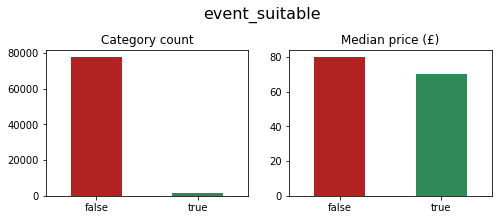

In [552]:
for col in df.iloc[:,39:-2].columns:
    binary_count_and_price_plot(col)

One way to reduce the number of features (due to the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed (e.g. if 90% of properties have internet, it is not worth including in the model as most properties have it. Or if only 5% of properties have a pool or hot tub, it should be removed because it doesn't apply to many properties).

One alternative would be to drop columns based on their impact on the target column 'price', e.g. if the median price doesn't vary much between properties with or without a coffee machine then the coffee machine feature should be dropped. However, while some of these features might not impact the median price on their own, there might be some underlying interactions that would be lost if the features were dropped (e.g. maybe people in one area of London really care about coffee machines, so it has a big impact on price there).Therefore sparsity will be used as the grounds on which to drop a column, rather than impact on the target.

In [594]:
# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
for col in df.iloc[:,39:-2].columns:
    if len(df[df[col] == 'f']) < len(df)/10 or len(df[df[col] == 't']) < len(df)/10:
        print(col)

check_in_24h
air_conditioning
high_end_electronics
bbq
bath
bathroom_essentials
nature_and_views
staff
dining_area
en_suite
gym
hot_tub_sauna_or_pool
internet
private_bathroom
smoking_allowed
accessible
event_suitable


# Preparing the data for modeling

- One-hot encode columns
- Check for multi-collinearity and remove any necessary columns
- Log-transform/standardise/normalise

***

# Building a neural network

In this section...

- Initial XGBoost model for baseline accuracy and feature importances

- Try with postcode districts, and then with lat/long
- Try with and without occupancy columns?
- Try after deleting categorical columns with predominantly one category (e.g. experiences offered)?
- Try with different standardisation/normalisation technique?
- Try different techniques for listings without reviews/host response times, i.e. those that haven't yet had a booking, e.g. dropping rows or columns entirely

***

# Conclusions and recommendations

Conclusions

**Potential directions for future work**
- Include a wider geographic area, e.g. other major cities around the world are available on Insideairbnb
- Use better quality/more accurate data with actual prices paid per night
- Augment the model with NLP of listing descriptions and/or reviews, e.g. for sentiment analysis or looking for keywords
- Augment the model with a convolutional neural network to attempt to assess the quality of images (images are hugely important on Airbnb)
- In addition to predicting base prices, a sequence model could be used to calculate daily rates using data on seasonality and occupancy